# Run snp2cell with GWAS scores

snp2cell package: https://github.com/Teichlab/snp2cell

In [1]:
import os
import snp2cell
import pandas as pd
import scanpy as sc

By default logging is set to "INFO". You can set it to "WARNING" to show less messages, or to "DEBUG" to show more. Adjusting the loglevel in a Jupyter notebook is a bit more complicated than in a plain python script, but the following cell should work if you want to adjust the log-level:

In [2]:
import logging

level = logging.INFO

logger = logging.getLogger()
logger.setLevel(level)
for handler in logger.handlers:
    handler.setLevel(level)

The default number of parallel jobs to use can be set globally. `snp2cell` can run on a standard computer and multiple CPUs are not necessary, but it can speed up the computations.

In [3]:
snp2cell.util.set_num_cpu(16)  # set the number of parallel jobs to use

In [4]:
print(f"using #CPUs: {snp2cell.NCPU} of {os.cpu_count()}")

using #CPUs: 16 of 24


## params

To run `snp2cell` we need:
  - a gene regulatory network (GRN)
  - scores for the nodes of the network

The GRN has to be provided as a [networkx](https://networkx.org/documentation/stable/reference/index.html) graph and scores as python dictionaries mapping the network nodes to numbers. In principle the method is quite flexible GRN in which GRNs and scores can be used.

Here, we want to use an eGRN (a GRN with transcription factors (TF), genes and genomic regions bound by the TFs) and scores obtained from GWAS summary statistics. Then, we also want to overlap the GWAS scores with cell type specificity scores obtained from single cell data. For all of these steps there are helper functions to add the scores.

In the end, we will have a `snp2cell` object with multiple scores:
  - 1 GWAS based score
  - multiple differential expression based scores, 1 for each cell type
  - multiple overlap scores, 1 for each cell type combined with the GWAS based score

In our case we will use (subsampled) lung datasets, including the eGRN as networkx graph, a single cell AnnData object of adult lung, and GWAS summary statistics from a study of COPD (GCST90244098). The overlap scores can then be seen as cell type specific disease association scores of transcription factors, genes, and genomic regions. By using network propagation, a transcription factor may be predicted with a large score if it regulates many genomic regions. This makes sense, as complex diseases often involve a large number of mutations across non-coding regions of the genome.

In [5]:
### input
nx_graph_path = "../files/lung_egrn_subset.pkl"  # networkx DiGraph object, pickled
anndata = "../files/adata_lung_subsampled.h5ad"  # single cell anndata object
study = "GCST90244098"  # name for the GWAS study

### object
s2c_object_path = f"s2c_{study}.pkl"  # snp2cell object

## 0) create snp2cell object

We start bt creating a `snp2cell` object. This will be used to store the scores we are going to compute. Then, we also add the networkx graph (GRN) to the object.

In [6]:
s2c = snp2cell.SNP2CELL()

In [7]:
s2c.add_grn_from_networkx(nx_graph_path)

In [8]:
s2c

GRN: DiGraph with 5000 nodes and 17797 edges
original scores: (5000, 0)
propagated scores: (5000, 0)
score perturbations for: None
adata: None

## 1) save peak locations for running getLDSC

Next, we want to add GWAS based scores, but first we have to compute the scoes. Different methods could be used to calculate scores for individual genes and genomic locations based on GWAS summary statistic. Here, we will compute Regional Bayes Factors (RBF) for genomic regions using an implementation in the `nf-fgwas` [pipeline](https://github.com/cellgeni/nf-fgwas). Steps 1) - 3) cover this process.

For this we need to export the genomic locations from our GRN. The following function can help with this, it will create files called `peak_locations.txt` and `peak_locations.txt.gz` that can be used as input for the nf-fgwas pipeline:

In [9]:
snp2cell.util.export_for_fgwas(s2c)

[INFO - export_for_fgwas - 2025-03-06 20:00:37,952]: saved 4025 region locations to 'peak_locations.txt' and 'peak_locations.txt.gz'.


## 2) run fGWAS nextflow pipeline on farm

pipeline repository: https://github.com/cellgeni/nf-fgwas

Then, we need to run the nf-fgwas pipeline. Unlike snp2cell itself, computing the Bayes Factors (BF) is time consuming and it is advised to run the calculations on a compute environment. That said, the pipeline is implemented in `nextflow`, which makes it easy to run in different environments. More instructions and link to download a Docker container can be found on the pipeline [GitHub repository](https://github.com/cellgeni/nf-fgwas).

The pipeline can be executed with a shell script somewhat like this...

```bash
#!/bin/bash

module load cellgen/singularity
module load cellgen/nextflow

NX_FILE="/path/to/nf-gwas/main.nf"

nextflow run $NX_FILE -resume -qs 1000 \
        --enrichment false \
        --window_size 5000 \
        --tss_file peak_locations.txt.gz \
        --cell_types peak_locations.txt \
        --studies summ_stat_paths.txt \
```

## 3) calculate RBF per location

Finally we need to load the Bayes Factors computed with the `nf-fgwas` pipeline and compute log(RBF) values as scores.

In [10]:
scores, tbl = snp2cell.util.load_fgwas_scores(
    fgwas_output_path = f"fgwas/results/LDSC_results/{study}/input.gz",
    region_loc_path = "peak_locations.txt",
)

[INFO - load_fgwas_scores - 2025-03-06 20:00:37,957]: using 16 cores
[INFO - load_fgwas_scores - 2025-03-06 20:00:37,958]: loading fgwas output from 'fgwas/results/LDSC_results/GCST90244098/input.gz'
[INFO - load_fgwas_scores - 2025-03-06 20:00:38,656]: loading region locations from 'peak_locations.txt'
[INFO - load_fgwas_scores - 2025-03-06 20:00:38,663]: calculating regional Bayes factors
Calculating RBFs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3994/3994 [00:01<00:00, 3166.44it/s]
[INFO - load_fgwas_scores - 2025-03-06 20:00:41,013]: adding region information to scores
[INFO - load_fgwas_scores - 2025-03-06 20:00:41,046]: expanding region locations by -250 and +250 bp and returning 4025 scores


In [11]:
tbl.sort_values('log_RBF', ascending=False).head()

,hm_chr,hm_pos,log_RBF,name,ID
1008,4,105896645,344.752034,chr4:105896645-105896645,1008
1007,4,105896087,344.450245,chr4:105896087-105896087,1007
1006,4,105895383,344.115852,chr4:105895383-105895383,1006
1005,4,105894764,343.756361,chr4:105894764-105894764,1005
1009,4,105902736,343.479973,chr4:105902736-105902736,1009


## 4) add scores to object

We then add these GWAS based scores to the `snp2cell` object. 

>Note that multiple scores (e.g. for different traits) can be added to the same object. Here we will continue with just one score.

In [12]:
s2c.add_score(
    score_dct = scores,
    score_key = study,
    num_cores = 16,
)

[INFO - add_score - 2025-03-06 20:00:41,111]: adding score: GCST90244098
[INFO - add_score - 2025-03-06 20:00:41,117]: propagating score: GCST90244098
[INFO - add_score - 2025-03-06 20:00:41,205]: storing score GCST90244098
[INFO - rand_sim - 2025-03-06 20:00:41,208]: create 1000 permutations
[INFO - loop_parallel - 2025-03-06 20:00:42,925]: using 16 cores
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.85it/s]
[INFO - add_score_statistics - 2025-03-06 20:01:02,501]: adding statistics


We save the progress, so we can continue from there later:

In [13]:
s2c.save_data(s2c_object_path)

[INFO - save_data - 2025-03-06 20:01:03,792]: saved data to: '/lustre/scratch127/cellgen/cellgeni/jp30/snp2cell_test/s2c_GCST90244098.pkl'


## 5) add cell-type scores

Next, we will add cell type specificity scores based on differential expression (DE) using a single cell data.

To load the `snp2cell` object, in case we restarted the notebook, simply run:

In [14]:
s2c = snp2cell.SNP2CELL(s2c_object_path)

### load anndata

We load an AnnData object with the adult lung single cell data. The object contains a cell annotation `broad_annot` and has a matrix with log-normalized counts.

In [15]:
ad = sc.read_h5ad(anndata)

In [16]:
ad

AnnData object with n_obs × n_vars = 5022 × 36601
    obs: 'broad_annot'
    var: 'gene_ids'
    uns: 'log1p'

In [17]:
ad.X.min(), ad.X.max()

(0.0, 7.0963807)

### add anndata to snp2cell object

Then we add the AnnData object to snp2cell and calculate DE scores for each cell type. This basically performs DE analysis for each cell type versus all others, and then adds these scores to the object.

>Note: if you want to customise score computation more, you can also easily compute DE yourself and then add the scores in a loop using `s2c.add_score()`.

In [18]:
s2c.link_adata(ad)

In [19]:
s2c.adata_add_de_scores(
    groupby = "broad_annot",
)

[INFO - adata_add_de_scores - 2025-03-06 20:01:04,901]: finding DE genes for annotation broad_annot
[INFO - adata_add_de_scores - 2025-03-06 20:01:04,902]: running scanpy rank_genes_groups...
/home/ubuntu/mambaforge/envs/snp2cell/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
[INFO - adata_add_de_scores - 2025-03-06 20:01:22,682]: ranking by upregulation...
[INFO - add_score - 2025-03-06 20:01:22,821]: adding score: DE_Chondrocyte__score
[INFO - add_score - 2025-03-06 20:01:22,985]: adding score: DE_Alveolar_type_1__score
[INFO - add_score - 2025-03-06 20:01:23,145]: adding score: DE_Alveolar_type_2__score
[INFO - add_score - 2025-03-06 20:01:23,303]: adding score: DE_Mast__score
[INFO - add_score - 2025-03-06 20:01

If the AnnData object is very large, it can be good to remove it from the `snp2cell` object to keep the object smaller, by setting the corresponding attribute to None:

In [20]:
s2c.adata = None

### combine expression and GWAS scores

We then compute overlap scores by combining the GWAS based score with each DE score.

>Note: If you want to add and combine scores manually, you can also use the `s2c.combine_scores()` method. The `s2c.combine_scores_rand()` method can then be used to add statitics to the object based on propagating random permutations. The adata* methods we use here do all of that automatically.

In [21]:
s2c

GRN: DiGraph with 5000 nodes and 17797 edges
original scores: (5000, 29)
propagated scores: (5000, 140)
score perturbations for: ['GCST90244098', 'DE_broad_annot__score']
adata: None

In [22]:
s2c.adata_combine_de_scores(
    group_key = "broad_annot",
    score_key = study,
    suffix = "__zscore_mad",
)

[INFO - combine_scores - 2025-03-06 20:06:18,895]: combining scores
[INFO - combine_scores_rand - 2025-03-06 20:06:18,910]: combining scores
[INFO - add_score_statistics - 2025-03-06 20:06:19,039]: adding statistics


In [23]:
s2c.save_data(s2c_object_path)

[INFO - save_data - 2025-03-06 20:06:36,190]: saved data to: '/lustre/scratch127/cellgen/cellgeni/jp30/snp2cell_test/s2c_GCST90244098.pkl'


## 6) explore

Finally, we can look at the scores. To get all scores you can use the method `s2c.get_scores()`. This returns a pandas DataFrame which can easily be processed further.

Overall, the DataFrame contains different scores:
  - the GWAS based score `GCST90244098`
  - cell type scores `DE_*__score`
  - overlap scores `min(GCST90244098,DE_*__score)`
  - and statistics and normalizations computed for each score

You can use pandas to filter the scores and genes you need. In addition, the `s2c.get_scores()` method provides several parameters to do the filtering. For example, the following selects all genes `~index.str.startswith('chr')` (regions start with "chr") and sorts them by the robust z-score (`GCST90244098__zscore_mad`), which measures the score relative to the median expected by random.

In [24]:
genes_sorted = s2c.get_scores(sort_key=f'{study}__zscore_mad', query="~index.str.startswith('chr')")
genes_sorted.head()

,GCST90244098,GCST90244098__pval,GCST90244098__FDR,GCST90244098__zscore,GCST90244098__zscore_mad,DE_Monocyte__score,DE_Smooth_muscle__score,DE_SMG_mucous__score,DE_Mast__score,DE_T__score,...,"min(DE_SMG_duct__score__zscore_mad,GCST90244098__zscore_mad)__zscore","min(DE_SMG_duct__score__zscore_mad,GCST90244098__zscore_mad)__zscore_mad","min(DE_Myoepithelial__score__zscore_mad,GCST90244098__zscore_mad)__pval","min(DE_Myoepithelial__score__zscore_mad,GCST90244098__zscore_mad)__FDR","min(DE_Myoepithelial__score__zscore_mad,GCST90244098__zscore_mad)__zscore","min(DE_Myoepithelial__score__zscore_mad,GCST90244098__zscore_mad)__zscore_mad","min(DE_Schwann__score__zscore_mad,GCST90244098__zscore_mad)__pval","min(DE_Schwann__score__zscore_mad,GCST90244098__zscore_mad)__FDR","min(DE_Schwann__score__zscore_mad,GCST90244098__zscore_mad)__zscore","min(DE_Schwann__score__zscore_mad,GCST90244098__zscore_mad)__zscore_mad"
NPNT,0.002575,0.000,0.000000,22.648034,39.995484,0.000045,0.010509,0.000535,0.000053,0.000050,...,84706.341500,183754.890649,0.0,0.0,779308.922293,1.690563e+06,0.0,0.0,28439.051217,61693.741209
INTS12,0.003234,0.000,0.000000,21.232612,37.657923,0.000093,0.002981,0.002305,0.000117,0.000105,...,62977.635508,95979.643838,0.0,0.0,427387.487036,6.513480e+05,0.0,0.0,16765.901983,25551.984606
GSTCD,0.001909,0.000,0.000000,15.592220,29.974656,0.000078,0.001806,0.001552,0.000097,0.000088,...,83230.231619,148980.307739,0.0,0.0,445714.781205,7.978179e+05,0.0,0.0,10960.150931,19618.815406
VTA1,0.001118,0.000,0.000000,10.003151,18.484446,0.000034,0.000022,0.000024,0.000041,0.000038,...,-39699.776479,-181602.422718,1.0,1.0,-39754.282602,-1.818518e+05,1.0,1.0,-106698.599839,-488082.469499
ADGRG6,0.001118,0.001,0.263158,8.688351,17.892195,0.000034,0.000022,0.000024,0.000041,0.000038,...,-23027.950117,-181602.422718,1.0,1.0,-23059.566491,-1.818518e+05,1.0,1.0,-61890.737078,-488082.469499


print top 50 genes

In [25]:
' '.join(genes_sorted[:50].index.tolist())

'NPNT INTS12 GSTCD VTA1 ADGRG6 HHIP ARHGEF38 PPA2 BCAR1 NUDT5 CFDP1 SESN1 BTN3A3 CDC123 SEC61A2 DHTKD1 TET2 ARMC2 MMP15 ADAM19 CAMK1D ADAMTSL3 BTN3A2 BTN3A1 HIST1H1D ARHGEF17 ARHGAP27 BTN2A1 ZKSCAN8 PLEKHM1 RPL23 HMGN4 HIST1H3D TSHZ3 RELT ZSCAN31 FAM13A NPM1 MTMR3 ZNRF1 BTN2A2 DENND6A SSH2 THSD4 HIST1H2BG DMPK TIGD2 HIST1H2AE CSNK2A2 DMWD'

specific genes

## 7) plot network

`s2c.plot_network()` plots a GRN centered around a selected gene. Neighboring genes are added to the plot in either up- or downstream direction, i.e. showing regulators or regulated genes. The color indicates the GWAS association score for genes and regions. Note, that the scores for regions are usually higher as we mapped the GWAS scores to regions first and then propagated them to genes and TFs.

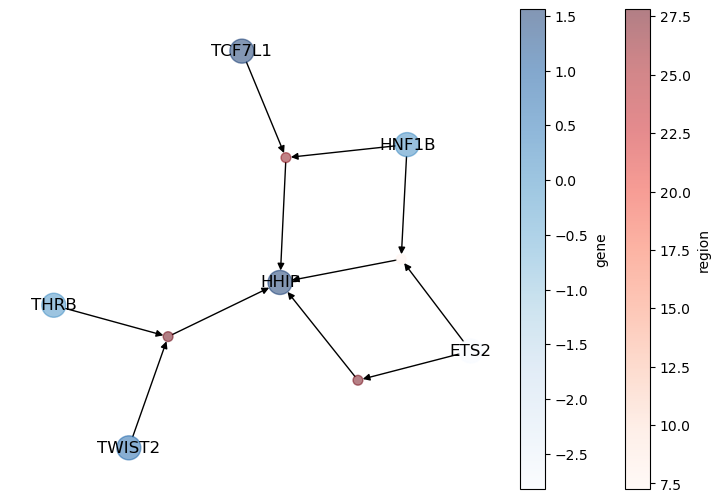

In [26]:
s2c.plot_network(score = "GCST90244098__zscore_mad", gene = "HHIP")

## 8) Per cell type plots

`s2c.plot_group_heatmap()` can be used to plot a "cell type x gene" heatmap, to show the scores of multiple individual nodes (i.e. genes, TFs and regions) and in which cell types they might have a stronger effect.

There are two ways to select values to plot:
  - use `s2c.get_scores()`, filter the data frame and pass the dataframe to `s2c.plot_group_heatmap(plt_df=plt_df)`
  - supply arguments to `s2c.plot_group_heatmap(score_key=study, query=...)` to do filtering and plotting in one step

>Note: The names of overlap scores (e.g. `min(GCST90244098__zscore_mad,DE_Ciliated__score__zscore_mad)__zscore_mad`) can be quite long. They can be renamed to just the cell type names using `plt_df.rename(columns=s2c.rename_column)` or by passing `row_pattern` to `s2c.plot_group_heatmap()` for extracting the cell type names.

In [27]:
plt_df = s2c.get_scores(
    query=f"~index.str.startswith('chr') and {study}__pval < 0.05",
    regex=f"^min.*{study}.*zscore_mad$",
)
plt_df = plt_df.rename(columns=s2c.rename_column)

In [28]:
plt_df.head()

,Chondrocyte,Alveolar_type_1,Alveolar_type_2,Mast,NK,Ciliated,Secretory_club,SMG_serous,SMG_mucous,B,...,Monocyte,Smooth_muscle,Endothelia_vascular_cap,Endothelia_vascular_ven,DC,Macrophage,Suprabasal,SMG_duct,Myoepithelial,Schwann
ADAM19,-13718.621049,-8.075015e+04,-1.182710e+05,17580.098576,256949.108030,-125661.828579,-7.167093e+04,-89733.017302,-61457.062609,256949.108030,...,-29237.488796,2.569491e+05,30790.269895,90715.413371,256949.108030,90924.200735,41617.867223,48594.216796,-1.415239e+04,-24843.150692
NPNT,-25653.288420,1.690563e+06,1.690563e+06,-36389.339925,-49731.606191,55684.880907,1.690563e+06,198948.810732,823548.124093,-19007.358001,...,-50490.048110,1.690563e+06,-11510.938723,-849.863770,-44179.386752,-45958.955156,99601.379622,183754.890649,1.690563e+06,61693.741209
CFDP1,-23286.738985,-1.602073e+04,-3.766985e+04,315748.533197,-29582.523036,315748.533197,5.986624e+04,-7922.094035,8405.225780,-38237.704699,...,-49960.888912,1.349372e+04,-18137.942556,-306.711303,-47388.745833,-16620.761339,88702.013903,13793.773413,1.606054e+04,54279.474296
HHIP,111690.455153,7.752383e+04,9.405278e+05,-41770.927828,-42545.906576,-42375.725965,9.289142e+04,-39818.437785,-10112.339331,-31060.782715,...,-20332.007501,-3.986833e+04,-9905.728808,-17631.463017,-30318.669619,-25404.400242,65331.763306,-34716.454456,9.919649e+04,-80500.680002
BCAR1,31635.055590,4.900469e+03,-4.910276e+04,550503.963449,6387.069143,550503.963449,2.352809e+05,-43443.474374,-12180.220255,-34311.343120,...,-59974.640791,6.522172e+04,19267.510216,50083.598099,-46292.728928,-3526.788475,40529.782685,-9202.825847,3.274791e+04,-28160.854354


`n_col` sets the number of cell types to show (ordered by mean score) and `genes_per_score` sets how many genes with largest score to select per cell type. If outliers make it difficult to see finer patterns, `transform=` can be used.

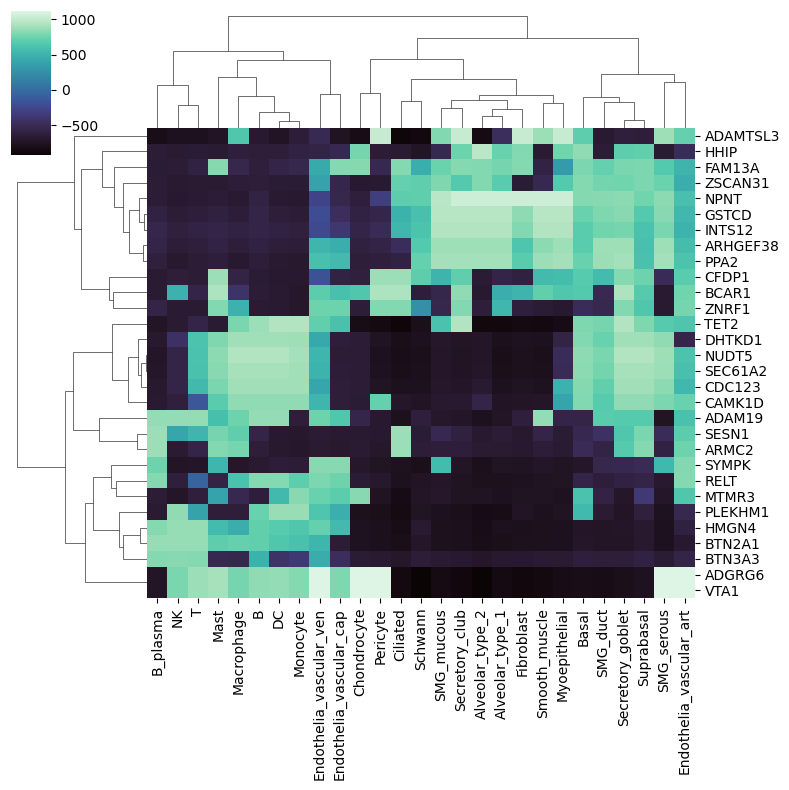

In [29]:
s2c.plot_group_heatmap(
    plt_df=plt_df,
    row_pattern=None,
    # score_key=study,
    # query=f"~index.str.startswith('chr') and {study}__pval < 0.05",
    n_col=30,
    genes_per_score=5,
    transform=("asinh",0.01),
    figsize=(8,8),
    dendrogram_ratio=(0.2,0.2),
)

We can also summarise all scores per cell type to rank the cell types. The `s2c.plot_group_summary()` works similarly to `s2c.plot_group_heatmap()` regarding score filtering. Here, we do filtering and plotting in just one command:

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

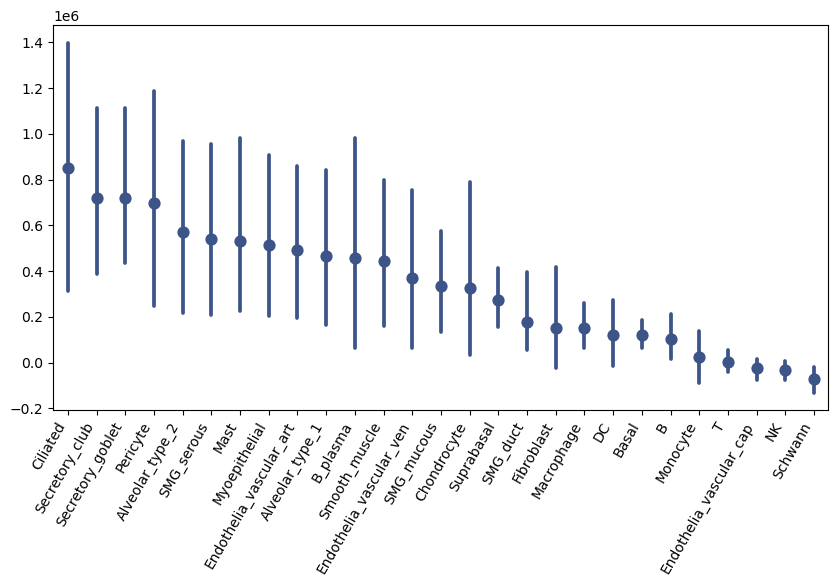

In [30]:
s2c.plot_group_summary(
    score_key=study,
    regex=f"^min.*{study}.*zscore_mad$",
    query=f"{study}__zscore_mad > 10",
    errorbar="ci",
    topn=30,
    figsize=(10,5),
)